# PHY432: Final Project:
# Gravitational Impacts of the Death Star on Endor and Earth-like Planets
### The Skywalkers

## Objective 2: Orbits

In [2]:
# PHY432: Final Project
# Team: The Skywalkers
# Members: Simon Tebeck, Pranav Gupta
# April 2024

# Objective 2: Orbits Earth

# import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")
import tqdm

# integrators
# import integrators



# =============================================================================
# 1. Initialising parameters
# =============================================================================


# gravitational constant
G_gravity = 4*np.pi**2 *(1/365.256)**2 # astronomical units but per days not years
yr = 365.256 # days

# astronomical unit
au =  1.495978e8 # km (!!)

def AU(x): return x/au
def AU_inv(x): return x*au


# masses
# SI
mass_sun = 1.9885E+30 # kg
mass_earth = 5.9724E+24 # kg
mass_moon = 7.346E+22 # kg
mass_endor = 7.52E+23 # kg
# mass_bb =


# Astronomical units
# DS_A: Death Star (light estimation)
# DS_B: Death Star (heavy estimation)
mass = {'Sun': 1.,
        'Earth': mass_earth/mass_sun,
        'Moon': mass_moon/mass_sun,
        'Endor': mass_endor/mass_sun,
        'DS_A': 1e18/mass_sun,
        'DS_B': 2.8e23/mass_sun
        }

# orbital period in Earth days
period = {'Earth': 365.256
          }

# speeds in AU/day
# for earth: use pre-determined speed at perihelion: 30.29 km/s
speed_earth = 30.29 * 3600*24 / au # speed earth around sun at perihelion
# for moon: speed at apogee: 0.966 km/s
speed_moon =  0.966 * 3600*24 / au # speed moon around earth at apogee
# for DS: number that lead to stable orbits
speed_DS = 3.99 * 3600*24 / au # speed DS around earth


# distance from the respective orbit center in AU
# note: Earth distance at perihelion (closest), Moon at apogee (farthest)
distance = {'Earth': 1.47098074e8 / au, # e8 is in km!!
            'Moon': 4.055e5 / au,
            'DS': 2.5e4 / au,
            }

# radii of the objects
radius = {'Sun':696000 / au,
          'Earth': 6357 / au,
          'Moon': 1737 / au,
          'Endor': 2450 / au,
          'BB': 74000 / au,
          'DS': 100 / au
          }


# =============================================================================
# 2. Functions for the orbit calculations (Solar System) (for Endor System
# see other file in Submission)
# =============================================================================

# note: Some of the following functions were inspired by HW07, code templates
# offered by Oliver Beckstein, modified by Simon Tebeck


def initial_position(distance, angle=0):
    """Calculate initial planet position.

    Parameters
    ----------
    angle : float
       initial angle relative to x axis (in degrees)
    distance : float
       initial distane from sun (in AU)

    Returns
    -------
    array
       position (x, y)
    """
    x = np.deg2rad(angle)
    return distance * np.array([np.cos(x), np.sin(x)])



def F_gravity(r, m, M):
    """Force due to gravity between two masses.

    Parameters
    ----------
    r : array
      distance vector (x, y)
    m, M : float
      masses of the two bodies

    Returns
    -------
    array
       force due to gravity (along r)
    """
    rr = np.sum(r * r)
    rhat = r / np.sqrt(rr)
    force_magnitude = - G_gravity * m * M / rr* rhat
    return force_magnitude


def omega(v, r):
    """Calculate angular velocity.

    The angular velocity is calculated as
    .. math::

          \omega = \frac{|\vec{v}|}{|\vec{r}|}

    Parameters
    ----------
    v : array
       velocity vectors for all N time steps; this
       should be a (N, dim) array
    r : array
       position vectors (N, dim) array

    Returns
    -------
    array
       angular velocity for each time step as 1D array of
       length N
    """
    speed = np.linalg.norm(v, axis=1)
    distance = np.linalg.norm(r, axis=1)
    return speed/distance


def dist(r1, r2):
    '''
    Parameters r1, r2: np.array of shape r = [x,y]
    Returns absolute value of the distance of connection vector
    '''
    return np.sqrt(np.sum((r1-r2)**2))


def crash_detect(r):
    '''
    Detect crashes of celestial bodies

    Parameters
    ----------
    r : np.array((3, 2))
        x and y positions of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for one time.

    Returns
    -------
    crash : bool
        did a crash happen? True or False.

    '''
    crash = False
    [r1, r2, r3] = r
    if dist(r1, [0,0]) < (radius['Sun']+radius['Earth']):
        print('\nEarth crashed into the Sun!')
        crash = True
    elif dist(r1, r2) < (radius['Moon']+radius['Earth']):
        print('\nMoon crashed into the Earth!')
        crash = True
    elif dist(r1, r3) < (radius['DS']+radius['Earth']):
        print('\nDeathstar crashed into the Earth!')
        crash = True
    elif dist(r3, np.array([0,0])) < (radius['DS']+radius['Sun']):
        print('\nDeathstar crashed into the Sun!')
        crash = True
        
    return crash


# calculate the total force
# r: input array [[x_Earth,y_Earth],[x_Moon,y_Moon],[x_DS,y_DS]]
def F_total(r, m_earth=mass['Earth'], m_DS=mass['DS_A'],
            sun=True, moon=False, DS=False, earth_fixed=False):
    '''
    Calculate the total force acting between the bodies due to
    Newton's law of Gravity

    Parameters
    ----------
    r : np.array((3, 2))
        x and y positions of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for one time.
    m_earth : float, optional,
        mass earth in sun masses, default is mass['Earth'].
    m_DS : float, optional
        mass Death Star in sun masses. The default is mass['DS_A'].
    sun : bool, optional
        Toggles forces of the sun on or off. The default is True.
    moon : bool, optional
        Toggles Moon on or off. The default is False.
    DS : bool, optional
        Toggles Death Star on or off. The default is False.
    earth_fixed : bool, optional
        Toggles whether Earth is held fixed on or off. The default is False.

    Returns
    -------
    F_tot : np.array((3, 2))
        F_x and F_Y total forces acting on Earth (index 0), Moon (index 1)
        and Death Star (index 2).

    '''
    
    # masses
    m_sun = mass['Sun']
    m_moon = mass['Moon']
    
    # radii of objects
    r_earth = r[0]
    r_moon = r[1]
    r_DS = r[2]
    
    # deactivate sun if only orbits around Earth shall be observed
    sunfactor = (1 if sun else 0) # ;)
    
    # deactivate forces acting on earth if earth should be held fixed
    earthfactor = (0 if earth_fixed else 1)
    
    # note: F_x_y means force points from y to x
    if moon:
        # simulate moon
        F_sun_moon = F_gravity(r_moon, m_moon, m_sun) * sunfactor
        F_earth_moon = F_gravity(r_moon-r_earth, m_moon, m_earth)
        
        if DS:
            # simulate DS
            F_sun_DS = F_gravity(r_DS, m_DS, m_sun) * sunfactor
            F_earth_DS = F_gravity(r_DS-r_earth, m_DS, m_earth)
            F_moon_DS = F_gravity(r_DS-r_moon, m_DS, m_moon)
        else:
            # no interactions with DS
            F_sun_DS = F_earth_DS = F_moon_DS = np.zeros(2)
    
    else:
        #no interactiosn with moon
        F_sun_moon = F_earth_moon = F_moon_DS = np.zeros(2)
        
        if DS:
            # simulate DS
            F_sun_DS = F_gravity(r_DS, m_DS, m_sun) * sunfactor
            F_earth_DS = F_gravity(r_DS-r_earth, m_DS, m_earth)
        else:
            # no interactions with DS
            F_sun_DS = F_earth_DS = np.zeros(2)
            
    # always: Earth-Sun
    F_sun_earth = F_gravity(r_earth, m_earth, m_sun) * sunfactor
    
    # total force
    F_tot = np.array([F_sun_earth - F_earth_moon - F_earth_DS,
                      F_sun_moon + F_earth_moon - F_moon_DS,
                      F_sun_DS + F_earth_DS + F_moon_DS])
    # account for fixed earht (=setting all forces acting on earth to zero)
    F_tot[0] *= earthfactor
    
    return F_tot
    


# main algorithm: integrate the orbits
def integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'], 
                     distance_DS=distance['DS'], _speed_DS=speed_DS,
                     dt=0.1, t_max=160, sun=True, moon=False, DS=False,
                     earth_fixed=False):
    '''
    Integrate Equations of motions with Velocity Verlet to calculate orbits

    Parameters
    ----------
    m_earth : float, optional,
        mass earth in sun masses, default is mass['Earth'].
    m_DS : float, optional
        mass Death Star in sun masses. The default is mass['DS_A'].
    distance_DS : float, optional
        distance Earth-DS in AU. The default is distance['DS'].
    _speed_DS : float, optional
        orbit speed of DS around Earth in AU/day. The default is speed_DS.
    dt : float, optional
        integration time step in days. The default is 0.1.
    t_max : float, optional
        max integration time in days. The default is 160.
    sun : bool, optional
        Toggles forces of the sun on or off. The default is True.
    moon : bool, optional
        Toggles Moon on or off. The default is False.
    DS : bool, optional
        Toggles Death Star on or off. The default is False.
    earth_fixed : bool, optional
        Toggles whether Earth is held fixed on or off. The default is False.

    Returns
    -------
    time : np.array((timesteps))
    rt : np.array((timesteps, 3, 2))
        x and y positions of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for all time steps.
    vt : np.array((timesteps, 3, 2))
        v_x and v_y velocities of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for all time steps.

    '''
    nsteps = int(t_max/dt)
    time = dt * np.arange(nsteps)
    
    # masses
    m_moon = mass['Moon']
    
    # speeds from global variables
    _speed_earth = speed_earth * (1 if sun else 0) # when sun neglected, see earth as center
    _speed_moon = speed_moon
    
    rt = np.zeros((nsteps, 3, 2)) # [[x_ea,y_ea],[x_mo,y_mo],[x_DS,y_DS]] for every time step
    vt = np.zeros_like(rt)
    
    # initialising earth
    rt[0,0,:] = initial_position(distance['Earth'])
    vt[0,0,:] = np.array([0, _speed_earth])
    
    # initialising moon
    rt[0,1,:] = initial_position(distance['Earth']) + np.array([0,distance['Moon']])
    vt[0,1,:] = np.array([- _speed_moon, _speed_earth])
    
    # initialising Death Star
    rt[0,2,:] = initial_position(distance['Earth']) + np.array([0,-distance_DS])
    vt[0,2,:] = np.array([1*_speed_DS, _speed_earth])
    
    # print(np.sqrt(np.sum((vt[0])**2, axis=1)))
    # print()

    # integration verlocity verlet
    Ft = F_total(rt[0], m_earth=m_earth, m_DS=m_DS, sun=sun, moon=moon, DS=DS,
                 earth_fixed=earth_fixed)
    
    for i in tqdm.tqdm(range(nsteps-1)):
        # print(vt[i,0])
        # print(dist(rt[i,2], np.array([0,0])), Ft[2])
        m = np.array([[m_earth, m_earth],
                     [m_moon, m_moon],
                     [m_DS, m_DS]])
        vhalf = vt[i] + 0.5 * dt * Ft / m
        rt[i+1] = rt[i] + dt * vhalf
    
        # new force
        Ft = F_total(rt[i+1], m_earth=m_earth, m_DS=m_DS, moon=moon, DS=DS,
                     sun=sun, earth_fixed=earth_fixed)
        # print(Ft[1])
        vt[i+1] = vhalf + 0.5 * dt * Ft / m
        # print(np.sqrt(np.sum((vt[i+1])**2, axis=1)))
        
        # crash detection: important to stop, otherwise F explodes
        if crash_detect(rt[i+1]):
            print('STOP SIMULATION')
            print('CELESTIAL CATASTROPHE, PEOPLE DIED!')
            # set all remaining r to the current r[i]
            rt = np.where(rt==np.zeros((3,2)), rt[i+1], rt)
            break

    return time, rt, vt


def orbit_time(r, t, neglect_first=100, eps=1e-4):
    '''
    Calculate the period it takes an object to complete an orbit

    Parameters
    ----------
    r : np.array((timesteps, 1, 2))
        x and y positions of the desired object for all time steps.
        use slicing to select Earth (0), Moon(1) or the DS(2)
    t : np.array((timesteps))
    neglect_first : int, optional
        How many entries in the r-array shall be neglected. The default is 100.
    eps : float, optional
        threshold for how close the Earth has to come back to the initial
        position for the period to be seen as completed. The default is 1e-4.

    Returns
    -------
    period_time: float
        period time of Earth. =0 when time could not be calculated

    '''
    r0 = r[0]
    period_time = 0
    for index, ri in enumerate(r[neglect_first:]):
        if dist(r0, ri) < eps:
            print('Orbit time successfully calculated.')
            period_time = time[neglect_first + index]
            break
    else:
        print('Orbit time could NOT be calculated.')
    return period_time


def stretch_distance(rt, index=1, alpha=30):
    '''
    Stretch distance of objects with respect to Earth (better visibility)

    Parameters
    ----------
    rt : np.array((timesteps, 3, 2))
        x and y positions of the objects Earth (index 0), Moon (index 1)
        and Death Star (index 2) for all time steps.
    index : int, optional
        1 for Moon, 2 for Death Star. The default is 1.
    alpha : float, optional
        value the distance will be stretched with. The default is 30.

    Returns
    -------
    rt : np.array((timesteps, 3, 2))
        new x and y positions with stretched distances
    str
        String for documentation purposes.

    '''
    r1 = rt[:,0]
    r2 = rt[:,index]
    rt[:,index] = r1 + alpha * (r2 - r1)
    return rt, '(stretched)'

In [3]:
import moviepy.editor as mpy
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.offsetbox import AnchoredText

### Plots or orbits

100%|████████████████████████████████████████████████████████████████████████████| 3651/3651 [00:01<00:00, 3106.11it/s]


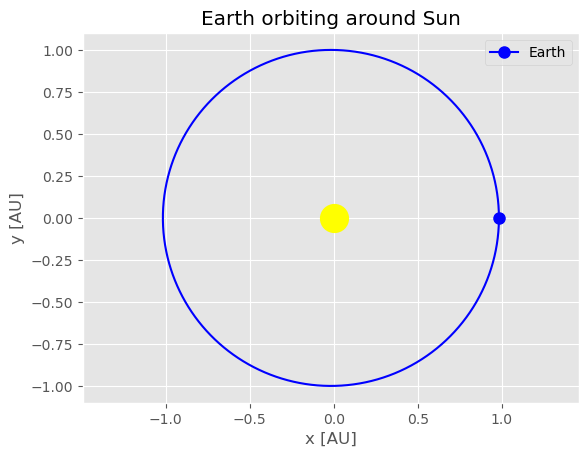

In [3]:
# Orbit of Earth around the Sun
dt=1e-1 # days
t_max=yr # days

time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'],
                                 sun=True, moon=False, DS=False, dt=dt, t_max=t_max,
                                 earth_fixed=False)

plt.plot(r[:,0,0], r[:,0,1], c='b')
plt.plot(r[0,0,0], r[0,0,1], marker='o', c='b', markersize=8, label='Earth')
plt.plot(0,0, marker='o', markersize=20, color='yellow')
plt.title('Earth orbiting around Sun')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()
plt.axis('equal')
# plt.savefig('sun_earth.png', dpi=300, bbox_inches='tight')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 3651/3651 [00:00<00:00, 3686.58it/s]


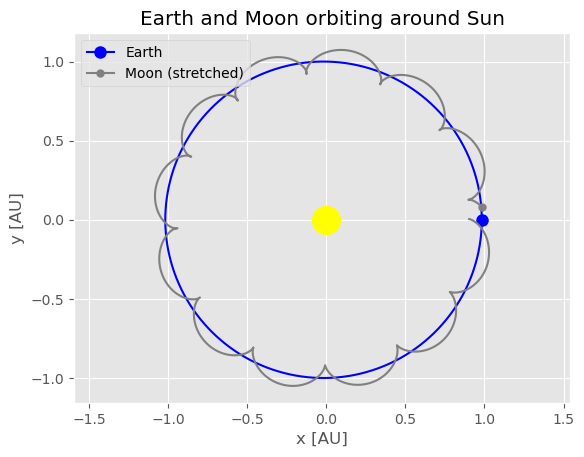

In [52]:
# orbit of Earth with Moon around Sun
dt=1e-1
t_max=yr

moon_stretch = ''

time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'],
                                 sun=True, moon=True, DS=False, dt=dt, t_max=t_max,
                                 earth_fixed=False)

r, moon_stretch = stretch_distance(r, 1)

plt.plot(r[:,0,0], r[:,0,1], c='b')
plt.plot(r[0,0,0], r[0,0,1], marker='o', c='b', markersize=8, label='Earth')

plt.plot(r[:,1,0], r[:,1,1], c='grey')
plt.plot(r[0,1,0], r[0,1,1], marker='o', c='grey', markersize=5, label=f'Moon {moon_stretch}')

plt.plot(0,0, marker='o', markersize=20, color='yellow')
title='Earth and Moon orbiting around Sun'
plt.title(title)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend(loc=2)
plt.axis('equal')
# plt.savefig('sun_earth_moon.png', dpi=300, bbox_inches='tight')
plt.show()

Moviepy - Building video sun_earth_moon.mp4.
Moviepy - Writing video sun_earth_moon.mp4



Moviepy - Done !
Moviepy - video ready sun_earth_moon.mp4


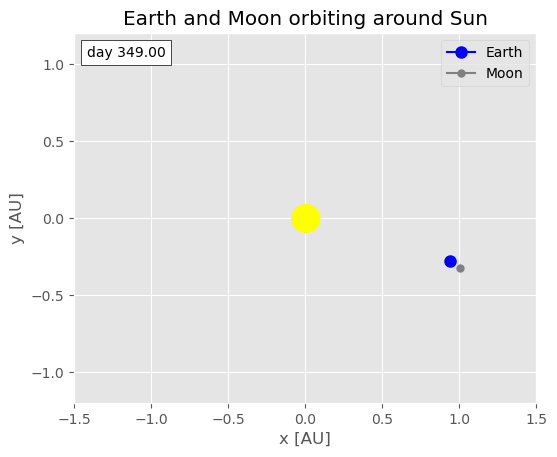

In [53]:
duration = 14
fps = 25
max_frame = int(duration*fps)

y_limits = -1.2, 1.2
x_limits = -1.5, 1.5

fig, ax = plt.subplots()

skip = 10
r = r[::skip]

def make_frame(t):
    global r, dt, x_limits, y_limits, fps, title, skip
    frame = int(t*fps)
    
    ax.clear()
    ax.set_title(title)
    ax.set_xlabel("x [AU]")
    ax.set_ylabel("y [AU]")
    ax.add_artist(AnchoredText(f'day {frame*dt*skip:.2f}', loc=2))
    ax.plot(r[frame,0,0], r[frame,0,1], marker='o', c='b', markersize=8, label='Earth')
    ax.plot(r[frame,1,0], r[frame,1,1], marker='o', c='grey', markersize=5, label='Moon')
    # ax.plot(r[frame,2,0], r[frame,2,1], marker='o', c='black', markersize=5, label='DS')
    ax.legend()
    ax.set_aspect('equal', 'box')
    ax.set(xlim=(x_limits), ylim=(y_limits))
    ax.plot(0,0, marker='o', markersize=20, color='yellow')
    return mplfig_to_npimage(fig)
    
if max_frame < len(r):
    filename = 'sun_earth_moon.mp4'
    animation = VideoClip(make_frame, duration=duration)
    animation.write_videofile(filename, fps=fps)
mpy.ipython_display(filename, autoplay=True, loop=True)

100%|██████████████████████████████████████████████████████████████████████████| 19999/19999 [00:04<00:00, 4765.97it/s]


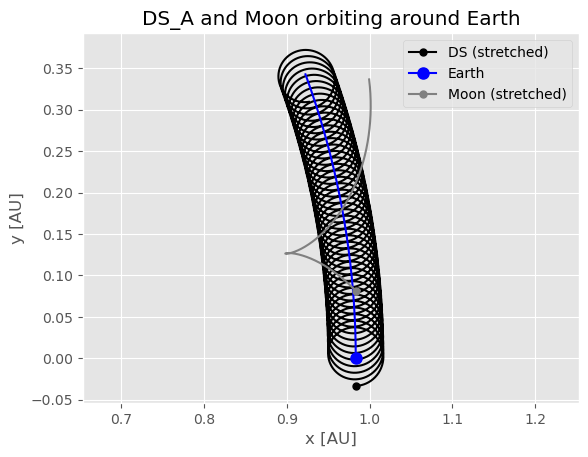

In [27]:
# orbit of Earth with Moon and DS_A around Sun (short)
dt=1e-3
t_max=20

moon_stretch = ''
DS_stretch = ''

time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'],
                                 sun=True, moon=True, DS=True, dt=dt, t_max=t_max,
                                 earth_fixed=False)

r, moon_stretch = stretch_distance(r, 1)
r, DS_stretch = stretch_distance(r, 2, 200)

plt.plot(r[:,2,0], r[:,2,1], c='black')
plt.plot(r[0,2,0], r[0,2,1], marker='o', c='black', markersize=5,
         label=f'DS {DS_stretch}')

plt.plot(r[:,0,0], r[:,0,1], c='b')
plt.plot(r[0,0,0], r[0,0,1], marker='o', c='b', markersize=8, label='Earth')

plt.plot(r[:,1,0], r[:,1,1], c='grey')
plt.plot(r[0,1,0], r[0,1,1], marker='o', c='grey', markersize=5, 
         label=f'Moon {moon_stretch}')

    
# plt.plot(0,0, marker='o', markersize=20, color='yellow')
title = 'DS_A and Moon orbiting around Earth'
plt.title(title)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()
plt.axis('equal')
# plt.savefig('sun_earth_moon_DS_A.png', dpi=300, bbox_inches='tight')
plt.show()

Moviepy - Building video sun_earth_moon_DS_A.mp4.
Moviepy - Writing video sun_earth_moon_DS_A.mp4



Moviepy - Done !
Moviepy - video ready sun_earth_moon_DS_A.mp4


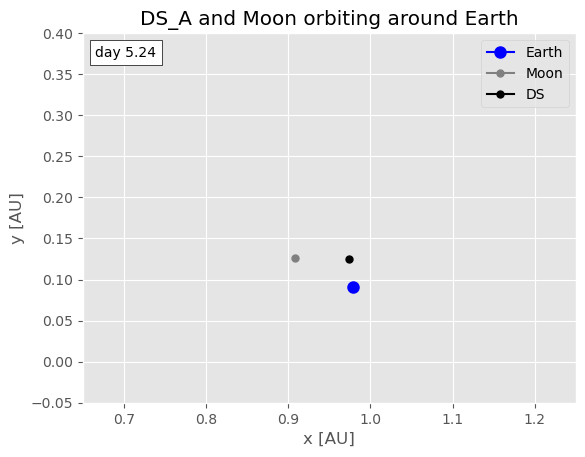

In [28]:
duration = 15
fps = 25
max_frame = int(duration*fps)

y_limits = -0.05, 0.4
x_limits = 0.65, 1.25

fig, ax = plt.subplots()

skip = 14
r = r[::skip]

def make_frame(t):
    global r, dt, x_limits, y_limits, fps, title, skip
    frame = int(t*fps)
    
    ax.clear()
    ax.set_title(title)
    ax.set_xlabel("x [AU]")
    ax.set_ylabel("y [AU]")
    ax.add_artist(AnchoredText(f'day {frame*dt*skip:.2f}', loc=2))
    ax.plot(r[frame,0,0], r[frame,0,1], marker='o', c='b', markersize=8, label='Earth')
    ax.plot(r[frame,1,0], r[frame,1,1], marker='o', c='grey', markersize=5, label='Moon')
    ax.plot(r[frame,2,0], r[frame,2,1], marker='o', c='black', markersize=5, label='DS')
    ax.legend()
    ax.set_aspect('equal', 'box')
    ax.set(xlim=(x_limits), ylim=(y_limits))
    # ax.plot(0,0, marker='o', markersize=20, color='yellow')
    return mplfig_to_npimage(fig)

if max_frame < len(r):
    filename = 'sun_earth_moon_DS_A.mp4'
    animation = VideoClip(make_frame, duration=duration)
    animation.write_videofile(filename, fps=fps)
mpy.ipython_display(filename, autoplay=True, loop=True)

In [57]:
mpy.ipython_display('sun_earth_moon_DS_A.mp4', autoplay=True, loop=True)

100%|████████████████████████████████████████████████████████████████████████| 365254/365254 [01:15<00:00, 4807.94it/s]


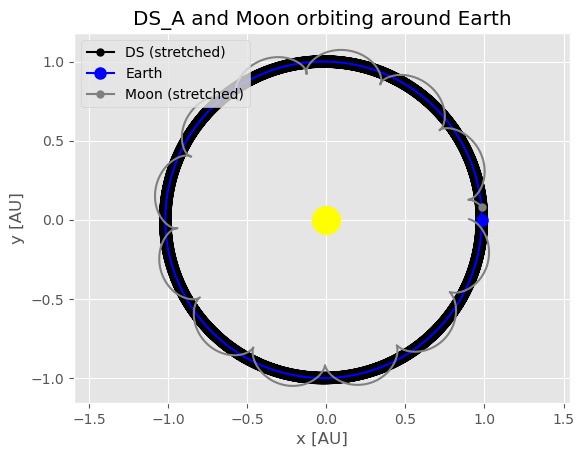

In [29]:
# orbit of Earth with Moon and DS_A around Sun (long)
dt=1e-3
t_max= yr

moon_stretch = ''
DS_stretch = ''

time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'],
                                 sun=True, moon=True, DS=True, dt=dt, t_max=t_max,
                                 earth_fixed=False)

r, moon_stretch = stretch_distance(r, 1)
r, DS_stretch = stretch_distance(r, 2, 200)

plt.plot(r[:,2,0], r[:,2,1], c='black')
plt.plot(r[0,2,0], r[0,2,1], marker='o', c='black', markersize=5,label=f'DS {DS_stretch}')

plt.plot(r[:,0,0], r[:,0,1], c='b')
plt.plot(r[0,0,0], r[0,0,1], marker='o', c='b', markersize=8, label='Earth')

plt.plot(r[:,1,0], r[:,1,1], c='grey')
plt.plot(r[0,1,0], r[0,1,1], marker='o', c='grey', markersize=5, label=f'Moon {moon_stretch}')

plt.plot(0,0, marker='o', markersize=20, color='yellow')
title = 'DS_A and Moon orbiting around Earth'
plt.title(title)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend(loc=2)
plt.axis('equal')
# plt.savefig('sun_earth_moon_DS_A_long.png', dpi=300, bbox_inches='tight')
plt.show()

100%|████████████████████████████████████████████████████████████████████████| 365254/365254 [01:23<00:00, 4353.46it/s]


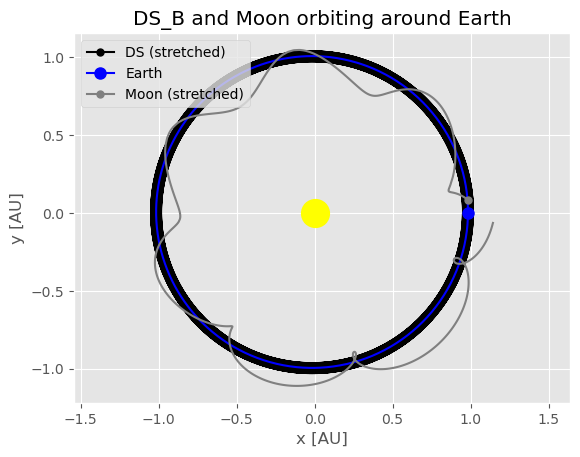

In [30]:
# orbit of Earth with Moon and DS_B around Sun (long)
dt=1e-3
t_max= yr

moon_stretch = ''
DS_stretch = ''

time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_B'],
                                 sun=True, moon=True, DS=True, dt=dt, t_max=t_max,
                                 earth_fixed=False)

r, moon_stretch = stretch_distance(r, 1)
r, DS_stretch = stretch_distance(r, 2, 200)

plt.plot(r[:,2,0], r[:,2,1], c='black')
plt.plot(r[0,2,0], r[0,2,1], marker='o', c='black', markersize=5,label=f'DS {DS_stretch}')

plt.plot(r[:,0,0], r[:,0,1], c='b')
plt.plot(r[0,0,0], r[0,0,1], marker='o', c='b', markersize=8, label='Earth')

plt.plot(r[:,1,0], r[:,1,1], c='grey')
plt.plot(r[0,1,0], r[0,1,1], marker='o', c='grey', markersize=5, label=f'Moon {moon_stretch}')

plt.plot(0,0, marker='o', markersize=20, color='yellow')
title = 'DS_B and Moon orbiting around Earth'
plt.title(title)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend(loc=2)
plt.axis('equal')
# plt.savefig('sun_earth_moon_DS_B_long.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 27999/27999 [00:05<00:00, 4879.13it/s]


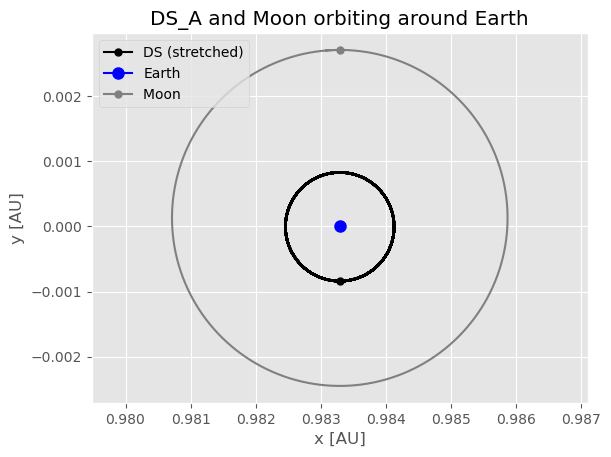

In [31]:
# orbit of Moon and DS_A around Earth
dt=1e-3
t_max= 28

moon_stretch = ''
DS_stretch = ''

time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'],
                                 sun=False, moon=True, DS=True, dt=dt, t_max=t_max,
                                 earth_fixed=True)

# r, moon_stretch = stretch_distance(r, 1)
r, DS_stretch = stretch_distance(r, 2, 5)

plt.plot(r[:,2,0], r[:,2,1], c='black')
plt.plot(r[0,2,0], r[0,2,1], marker='o', c='black', markersize=5,label=f'DS {DS_stretch}')

plt.plot(r[:,0,0], r[:,0,1], c='b')
plt.plot(r[0,0,0], r[0,0,1], marker='o', c='b', markersize=8, label='Earth')

plt.plot(r[:,1,0], r[:,1,1], c='grey')
plt.plot(r[0,1,0], r[0,1,1], marker='o', c='grey', markersize=5, label=f'Moon {moon_stretch}')

# plt.plot(0,0, marker='o', markersize=20, color='yellow')
title = 'DS_A and Moon orbiting around Earth'
plt.title(title)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend(loc=2)
plt.axis('equal')
# plt.savefig('earth_moon_DS_A.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 27999/27999 [00:05<00:00, 4731.39it/s]


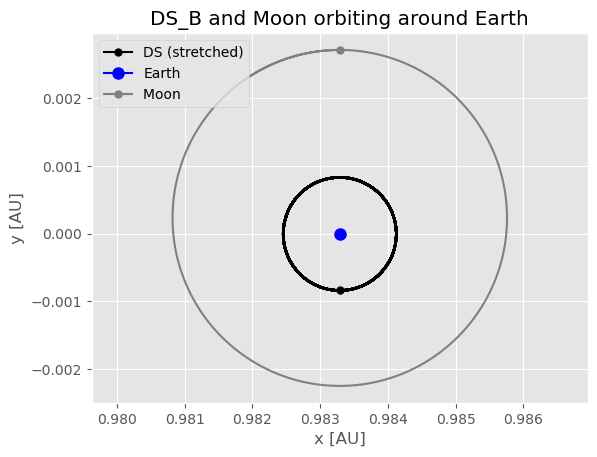

In [32]:
# orbit of Moon and DS_B around Earth
dt=1e-3
t_max= 28

moon_stretch = ''
DS_stretch = ''

time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_B'],
                                 sun=False, moon=True, DS=True, dt=dt, t_max=t_max,
                                 earth_fixed=True)

# r, moon_stretch = stretch_distance(r, 1)
r, DS_stretch = stretch_distance(r, 2, 5)

plt.plot(r[:,2,0], r[:,2,1], c='black')
plt.plot(r[0,2,0], r[0,2,1], marker='o', c='black', markersize=5,label=f'DS {DS_stretch}')

plt.plot(r[:,0,0], r[:,0,1], c='b')
plt.plot(r[0,0,0], r[0,0,1], marker='o', c='b', markersize=8, label='Earth')

plt.plot(r[:,1,0], r[:,1,1], c='grey')
plt.plot(r[0,1,0], r[0,1,1], marker='o', c='grey', markersize=5, label=f'Moon {moon_stretch}')

# plt.plot(0,0, marker='o', markersize=20, color='yellow')
title = 'DS_B and Moon orbiting around Earth'
plt.title(title)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend(loc=2)
plt.axis('equal')
# plt.savefig('earth_moon_DS_B.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# more orbits easily possible:
# earth moon
# earth DS_A
# earth DS_B
# last two with moon additionally

### Calculation of Angular velocity

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:01<00:00, 5786.84it/s]


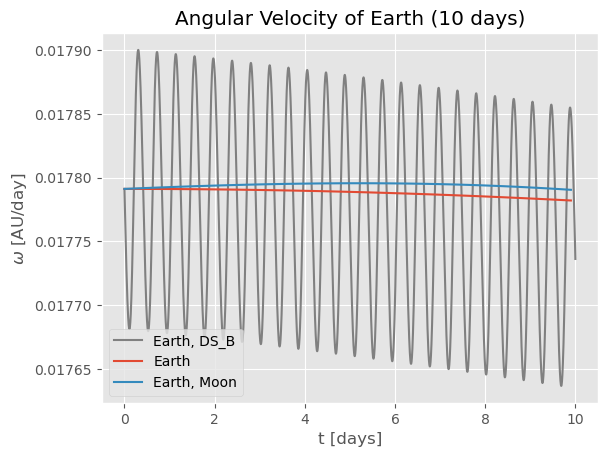

In [34]:
t_max = 10

dt=1e-1
time1, r1, v1 = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'],
                              moon=False, DS=False, dt=dt, t_max=t_max)
dt=1e-1
time2, r2, v2 = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_B'],
                              moon=True, DS=False, dt=dt, t_max=t_max)
dt=1e-3
time3, r3, v3 = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_B'],
                              moon=False, DS=True, dt=dt, t_max=t_max)

o1 = omega(v1[:,0], r1[:,0])
o2 = omega(v2[:,0], r2[:,0])
o3 = omega(v3[:,0], r3[:,0])
plt.plot(time3,o3, label='Earth, DS_B', c='grey')
plt.plot(time1,o1, label='Earth')
plt.plot(time2,o2, label='Earth, Moon')
plt.legend()
plt.xlabel('t [days]')
plt.ylabel('$\omega$ [AU/day]')
plt.title('Angular Velocity of Earth (10 days)')
# plt.savefig('omega_earth_10days.png', dpi=300, bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████| 365254/365254 [00:57<00:00, 6326.40it/s]


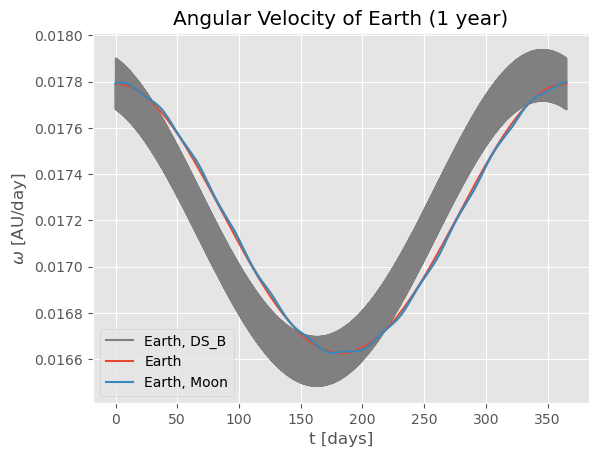

In [35]:
t_max = yr

dt=1e-1
time1, r1, v1 = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'],
                              moon=False, DS=False, dt=dt, t_max=t_max)
dt=1e-1
time2, r2, v2 = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_B'],
                              moon=True, DS=False, dt=dt, t_max=t_max)
dt=1e-3
time3, r3, v3 = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_B'],
                              moon=False, DS=True, dt=dt, t_max=t_max)

o1 = omega(v1[:,0], r1[:,0])
o2 = omega(v2[:,0], r2[:,0])
o3 = omega(v3[:,0], r3[:,0])
plt.plot(time3,o3, label='Earth, DS_B', c='grey')
plt.plot(time1,o1, label='Earth')
plt.plot(time2,o2, label='Earth, Moon')
plt.legend()
plt.xlabel('t [days]')
plt.ylabel('$\omega$ [AU/day]')
plt.title('Angular Velocity of Earth (1 year)')
# plt.savefig('omega_earth_1year.png', dpi=300, bbox_inches='tight')

### Calculating orbit periods

#### Orbit periods Earth

In [14]:
# Just earth with moon around sun

t_max = 370

dt=1e-2
time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'], moon=True, DS=False, dt=dt, t_max=t_max)
period_earth_1 = orbit_time(r[:,0], time, eps=3e-4)
print(f'Period Earth normal: {period_earth_1} days')

100%|██████████████████████████████████████████████████████████████████████████| 36999/36999 [00:06<00:00, 5616.09it/s]


Orbit time successfully calculated.
Period Earth normal: 365.37 days


The expected period is 365.25 days, so the simulation gives quite accurate results. The deviation of about 0.03% might be a result of the used simplifications in this model (perfectly spherical objects, no other sources of gravity, homogeneous densities).

In [37]:
# earth with moon and DS_A

t_max = 370

dt=1e-3
time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'], moon=True, DS=True, dt=dt, t_max=t_max)
period_earth_2 = orbit_time(r[:,0], time, eps=1e-4)
print(f'Period Earth with DS_A: {period_earth_2} days')
print(f'Deviation: {np.abs(1-period_earth_2/period_earth_1)*100:.4f} %')

100%|████████████████████████████████████████████████████████████████████████| 369999/369999 [01:18<00:00, 4685.45it/s]


Orbit time successully calculated.
Period Earth with DS_A: 365.374 days
Deviation: 0.0011 %


In [38]:
# earth with moon and DS_B

t_max = 370

dt=1e-3
time, r, v = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_B'], moon=True, DS=True, dt=dt, t_max=t_max)
period_earth_3 = orbit_time(r[:,0], time, eps=1e-3)
print(f'Period Earth with DS_B: {period_earth_3} days')
print(f'Deviation: {np.abs(1-period_earth_3/period_earth_1)*100:.4f} %')

100%|████████████████████████████████████████████████████████████████████████| 369999/369999 [01:16<00:00, 4852.35it/s]


Orbit time successully calculated.
Period Earth with DS_B: 365.338 days
Deviation: 0.0088 %


#### Orbit periods Moon

In [13]:
# Just earth with moon around sun

t_max = 30

dt=1e-3
time, r, v = integrate_orbits(m_DS=mass['DS_A'], sun=False, moon=True, DS=False, earth_fixed=True, dt=dt, t_max=t_max)
period_moon_1 = orbit_time(r[:,1], time, neglect_first=1000, eps=1e-4)
print(f'Period Moon normal: {period_moon_1} days')

100%|██████████████████████████████████████████████████████████████████████████| 29999/29999 [00:05<00:00, 5929.51it/s]


Orbit time successfully calculated.
Period Moon normal: 27.438 days


The result of 27.44 days for a period of the moon is not a bad result, given that the actual value is 27.32 days. The deviation of about 0.4% can be a result of simplifications that are used in this model, for example spherical shapes or perfectly homogeneous density distributions. In general however, this value shows that the simulation delivers good results. 

In [16]:
# earth with moon and DS_A

t_max = 30

dt=1e-3
time, r, v = integrate_orbits(m_DS=mass['DS_A'], sun=False, moon=True, DS=True, earth_fixed=True, dt=dt, t_max=t_max)
period_moon_2 = orbit_time(r[:,1], time, neglect_first=1000, eps=1e-4)
print(f'Period Moon with DS_A: {period_moon_2} days')
print(f'Deviation: {np.abs(1-period_moon_2/period_moon_1)*100:.4f} %')

100%|██████████████████████████████████████████████████████████████████████████| 29999/29999 [00:08<00:00, 3576.39it/s]


Orbit time successfully calculated.
Period Moon with DS_A: 27.438 days
Deviation: 0.0000 %


In [18]:
# earth with moon and DS_B

t_max = 30

dt=1e-3
time, r, v = integrate_orbits(m_DS=mass['DS_B'], sun=False, moon=True, DS=True, earth_fixed=True, dt=dt, t_max=t_max)
period_moon_3 = orbit_time(r[:,1], time, neglect_first=1000, eps=1e-4)
print(f'Period Moon with DS_B: {period_moon_3:.3f} days')
print(f'Deviation: {np.abs(1-period_moon_3/period_moon_1)*100:.4f} %')

100%|██████████████████████████████████████████████████████████████████████████| 29999/29999 [00:06<00:00, 4301.16it/s]


Orbit time successfully calculated.
Period Moon with DS_B: 25.243 days
Deviation: 7.9999 %


In [24]:
# Center of mass calculation
center_earth_moon = mass['Moon']*distance['Moon']/(mass['Earth']+mass['Moon']) / radius['Earth']
center_earth_DS_A = mass['DS_A']*distance['DS']/(mass['Earth']+mass['DS_A']) / radius['Earth']
center_earth_DS_B = mass['DS_B']*distance['DS']/(mass['Earth']+mass['DS_B']) / radius['Earth']
print(f'Center of mass Earth-Moon: {center_earth_moon:.3f}*r_earth')
print(f'Center of mass Earth-DS_A: {center_earth_DS_A:.3f}*r_earth')
print(f'Center of mass Earth-DS_B: {center_earth_DS_B:.3f}*r_earth')

Center of mass Earth-Moon: 0.775*r_earth
Center of mass Earth-DS_A: 0.000*r_earth
Center of mass Earth-DS_B: 0.176*r_earth
